In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pylab

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
#Image73.tif
#Image75.tif
#Image.tif
#Image2.tif
#Image3.tif
#Image4.tif

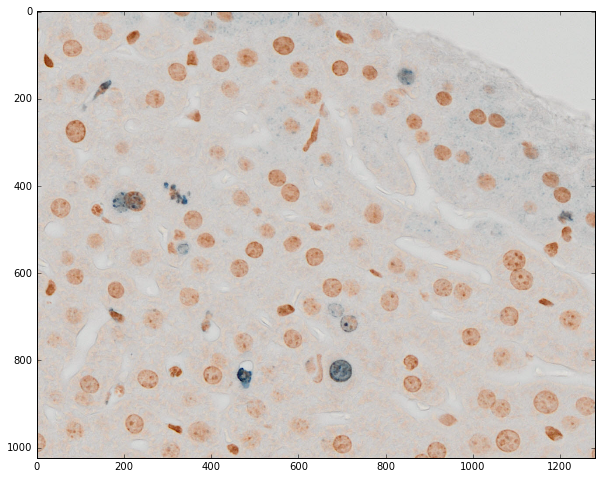

In [4]:
img = cv2.imread('Image75.tif')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

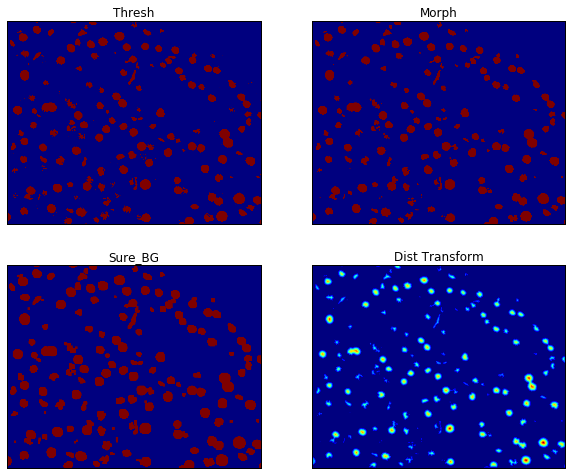

In [5]:
#ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
thresh = cv2.inRange(img, (0,0,0),(255,255,170))
im2, contour,h = cv2.findContours(thresh,cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    cv2.drawContours(thresh,[cnt],0,255,-1)
    
plt.subplot(2,2,1), plt.imshow(thresh)
plt.title("Thresh"), plt.xticks([]), plt.yticks([])

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.subplot(2,2,2), plt.imshow(opening)
plt.title("Morph"), plt.xticks([]), plt.yticks([])

sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.subplot(2,2,3), plt.imshow(sure_bg)
plt.title("Sure_BG"), plt.xticks([]), plt.yticks([])

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
plt.subplot(2,2,4), plt.imshow(dist_transform)
plt.title("Dist Transform"), plt.xticks([]), plt.yticks([])
plt.show()

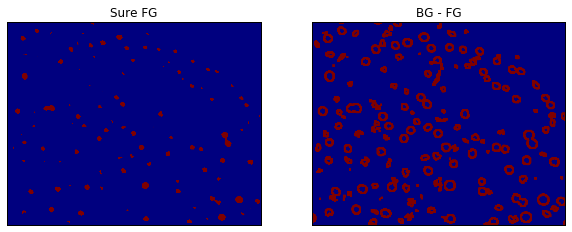

In [6]:
ret, sure_fg = cv2.threshold(dist_transform,0.35*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.subplot(1,2,1), plt.imshow(sure_fg)
plt.title("Sure FG"),  plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(unknown)
plt.title("BG - FG"),  plt.xticks([]), plt.yticks([])
plt.show()

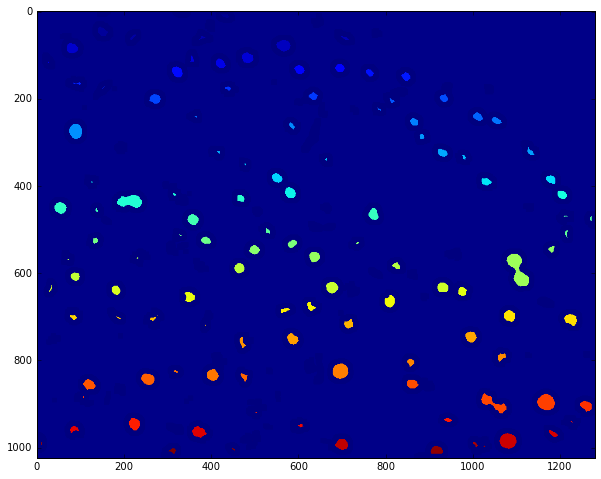

(<matplotlib.image.AxesImage at 0x1e32f902128>, None)

In [7]:
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1
markers[unknown == 255] = 0
plt.imshow(markers), plt.show()

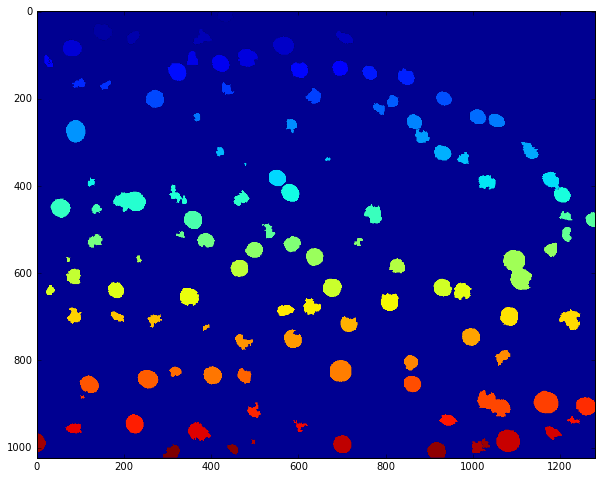

(<matplotlib.image.AxesImage at 0x1e32e497d30>, None)

In [8]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,255]
plt.imshow(markers), plt.show()

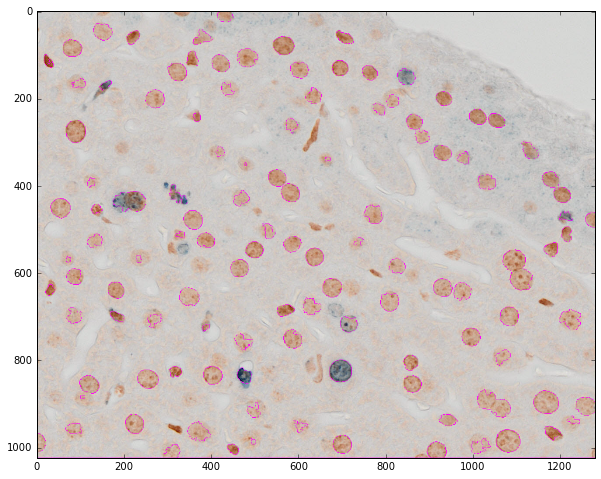

(None, -1)

In [9]:
plt.imshow(img), plt.show()
crop = cv2.resize(img, (640, 512))
cv2.imshow("Watershed", img), cv2.waitKey(-1)

In [10]:
#Test using both markers to put into one image
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

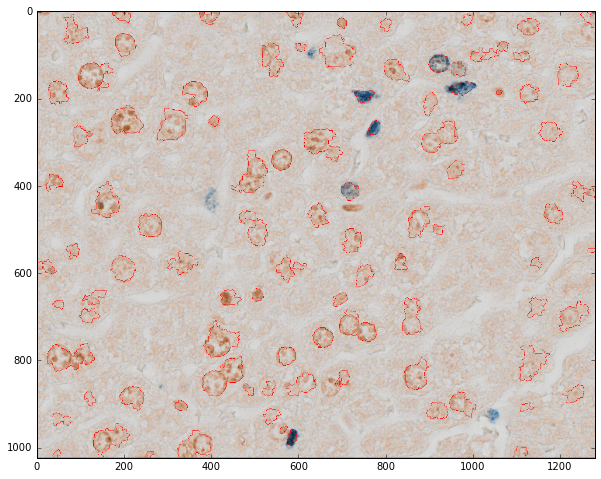

(None, -1)

In [11]:
img = cv2.imread("Image4.tif")
thresh = cv2.inRange(img, (0,0,0),(255,200,185))
#img = cv2.threshold(img, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
im2, contour,h = cv2.findContours(thresh,cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contour:
    cv2.drawContours(thresh,[cnt],0,255,-1)

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
sure_bg = cv2.dilate(opening, kernel, iterations = 3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

ret, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1

markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

plt.imshow(img), plt.show()
screen_res = 1280, 720
scale_width = screen_res[0] / img.shape[1]
scale_height = screen_res[1] / img.shape[0]
scale = min(scale_width, scale_height)
window_width = int(img.shape[1] * scale)
window_height = int(img.shape[0] * scale)

cv2.namedWindow('Watershed', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Watershed', window_width, window_height)
cv2.imshow("Watershed", img), cv2.waitKey(-1)

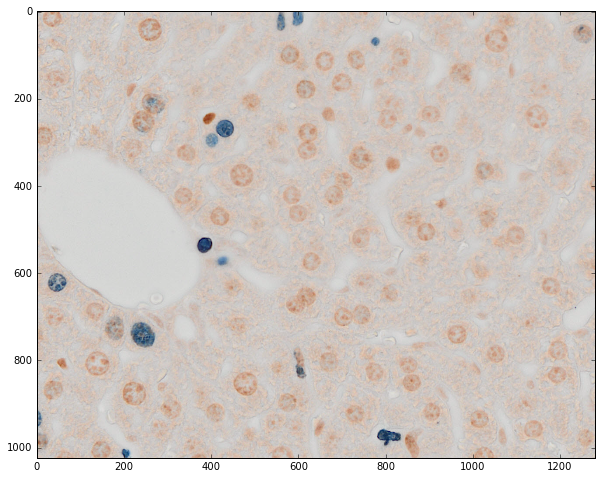

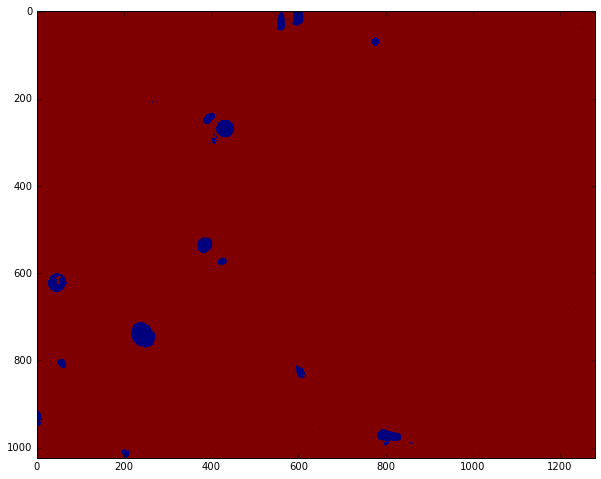

[INFO] 10 unique segments found


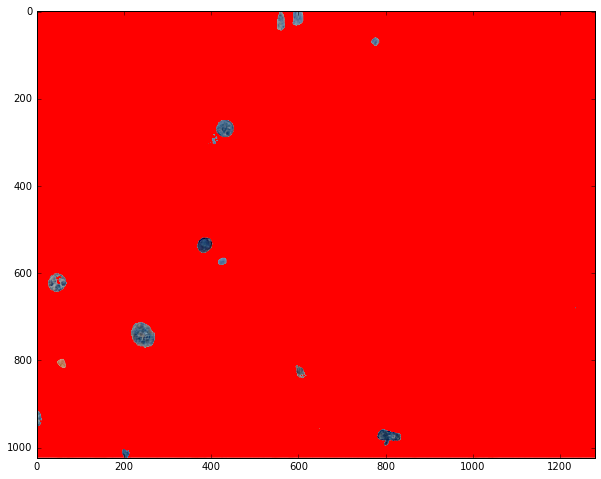

(<matplotlib.image.AxesImage at 0x1e3356c9f28>, None)

In [12]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage


image = cv2.imread("Image.tif")
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
plt.imshow(image), plt.show()
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh), plt.show()
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=10,
	labels=thresh)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
 
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    cv2.drawContours(image, cnts,0,255,-1)
    c = max(cnts, key=cv2.contourArea)
 
	# draw a circle enclosing the object
	#((x, y), r) = cv2.minEnclosingCircle(c)
	#cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	#cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 
# show the output image
plt.imshow(image), plt.show()

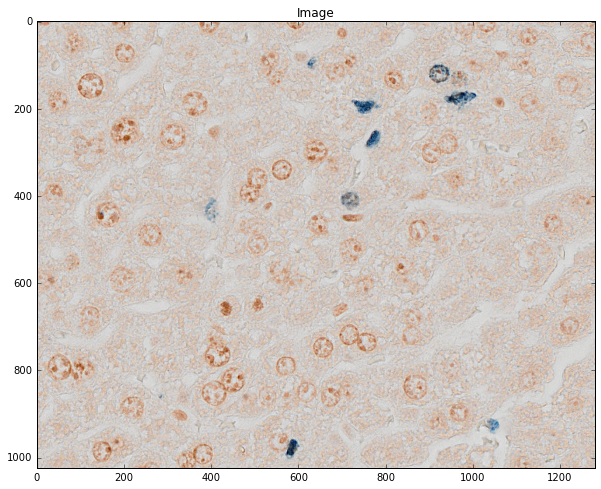

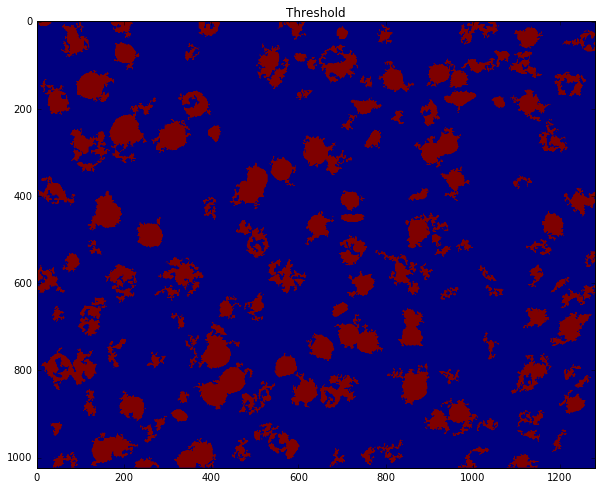

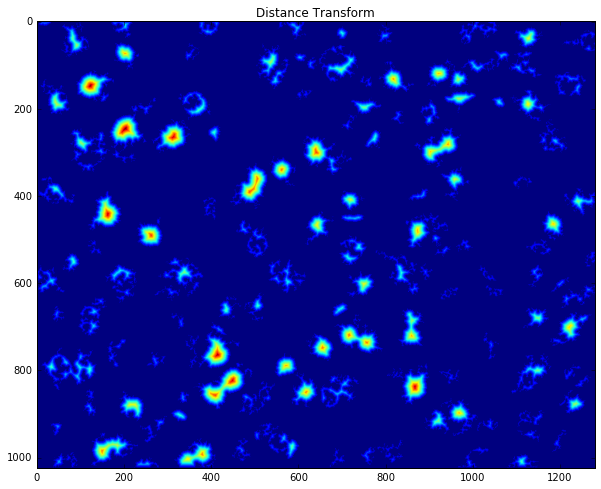

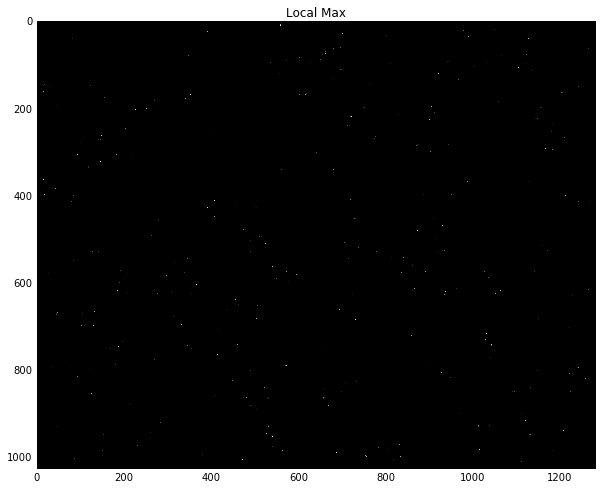

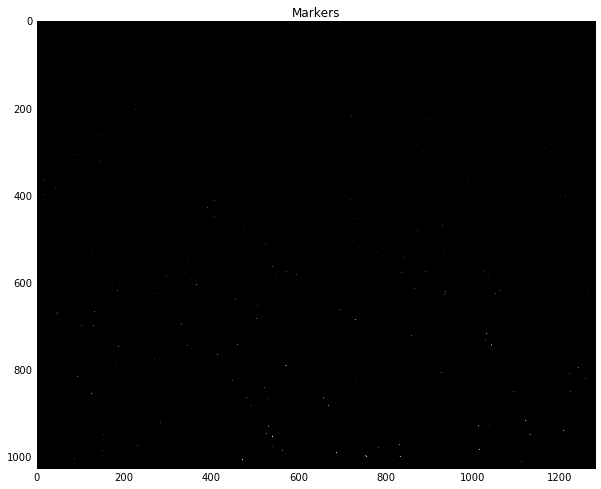

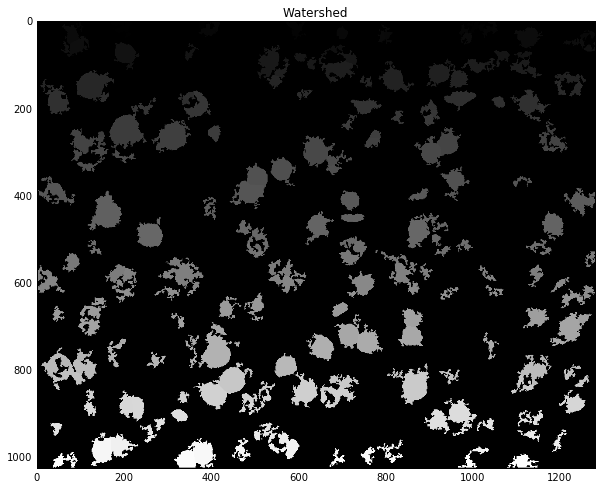

[INFO] 405 unique segments found


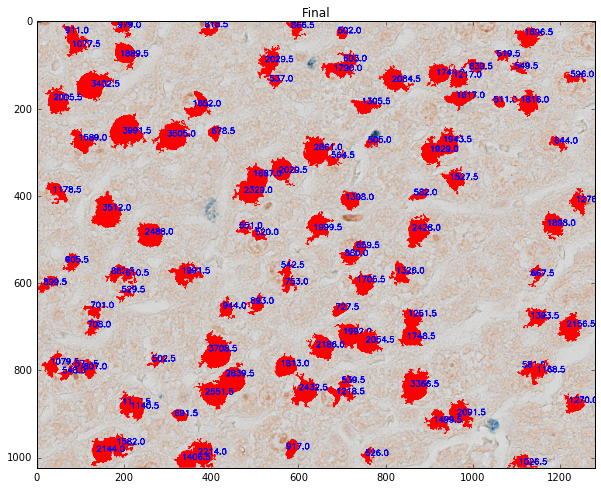

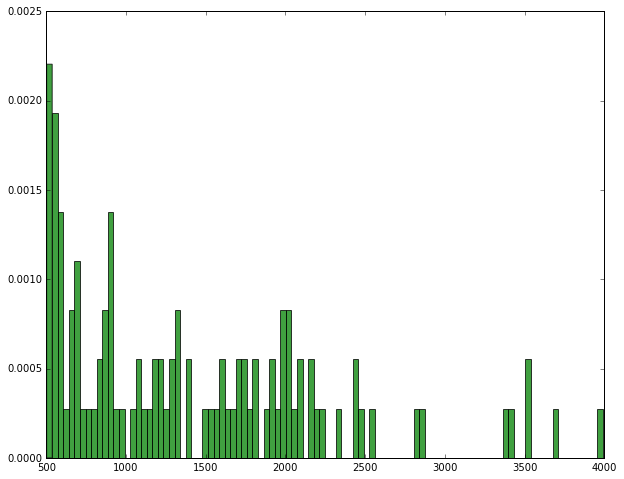

In [13]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage


image = cv2.imread("Image4.tif")
im = cv2.GaussianBlur(image, (0,0), 3)
image = cv2.addWeighted(image, 1.5, im, -0.5, 0)
#image = image[400:700, 400:700]
plt.imshow(image), plt.title("Image"), plt.show()
#shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
#plt.imshow(image), plt.show()
#gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
#thresh = cv2.threshold(image, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
#thresh = 255-thresh

thresh = cv2.inRange(image, (0,0,0),(255,255,180))
#thresh = 255 - thresh
#thresh = cv2.equalizeHist(thresh)
kernel = np.ones((3,3), np.uint8)
#thresh = cv2.dilate(thresh, kernel, iterations = 1)
im2, contour,h = cv2.findContours(thresh,cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)
for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)

plt.imshow(t1), plt.title("Threshold"), plt.show()
D = ndimage.distance_transform_edt(t1)

plt.imshow(D), plt.title("Distance Transform"), plt.show()
localMax = peak_local_max(D, indices=False, min_distance=10,labels=t1)
plt.imshow(localMax, cmap='gray'), plt.title("Local Max"), plt.show()

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=t1)

plt.imshow(markers, cmap = 'gray'), plt.title("Markers"), plt.show()
plt.imshow(labels, cmap = 'gray'), plt.title("Watershed"), plt.show()
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

ct = []
dt = []
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(t1.shape, dtype="uint8")
    mask[labels == label] = 255
    
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts:
        if (cv2.contourArea(c) > 500):
            ct.append(cv2.contourArea(c))
            cv2.drawContours(image, [c],0,255,-1)
            ((x, y), r) = cv2.minEnclosingCircle(c)
            cv2.putText(image, "{}".format(cv2.contourArea(c)), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    
    #cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    

plt.imshow(image), plt.title("Final"), plt.show()
screen_res = 1280, 720
scale_width = screen_res[0] / image.shape[1]
scale_height = screen_res[1] / image.shape[0]
scale = min(scale_width, scale_height)
window_width = int(image.shape[1] * scale)
window_height = int(image.shape[0] * scale)

cv2.namedWindow('Watershed', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Watershed', window_width, window_height)
cv2.imshow("Watershed", image), cv2.waitKey(-1)

n, bins, patches = plt.hist(ct, 100, normed=1, facecolor='green', alpha=0.75)
plt.show()

In [14]:
#FIXING THRESHOLD

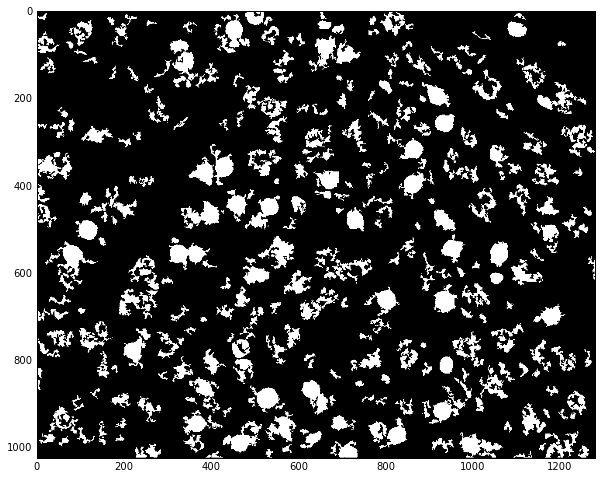

(<matplotlib.image.AxesImage at 0x1e32e6a4a20>, None)

In [15]:
img = cv2.imread("Dropbox/BrdUImgs/Image (41).tif")
im = cv2.GaussianBlur(img, (0,0), 3)
img = cv2.addWeighted(img, 1.5, im, -0.5, 0)
thresh = cv2.inRange(img, (0,0,0),(255,255,175))
_, contour,_ = cv2.findContours(thresh,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
t1 = np.zeros(thresh.shape, np.uint8)
for cnt in contour:
    area = cv2.contourArea(cnt)
    if area >= 100:
        cv2.drawContours(t1,[cnt],0,255,-1)
plt.imshow(t1, cmap = 'gray'), plt.show()

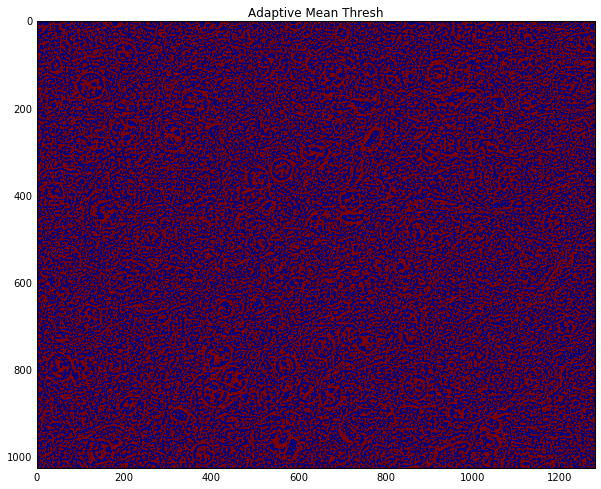

(<matplotlib.image.AxesImage at 0x1e32e835d68>,
 None)

In [16]:
img = cv2.imread("Image4.tif",0)
thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
plt.imshow(thresh), plt.title("Adaptive Mean Thresh"), plt.show()

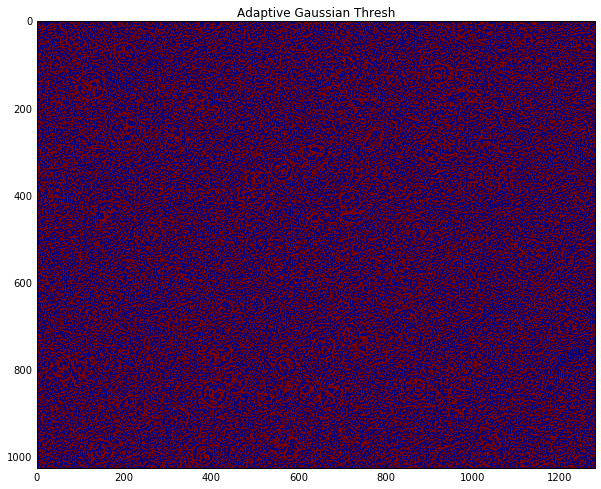

(<matplotlib.image.AxesImage at 0x1e32e810ef0>,
 None)

In [17]:
img = cv2.imread("Image4.tif",0)
thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
plt.imshow(thresh), plt.title("Adaptive Gaussian Thresh"), plt.show()

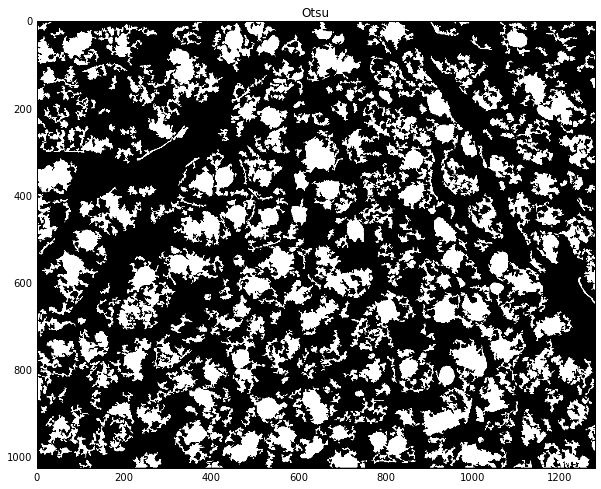

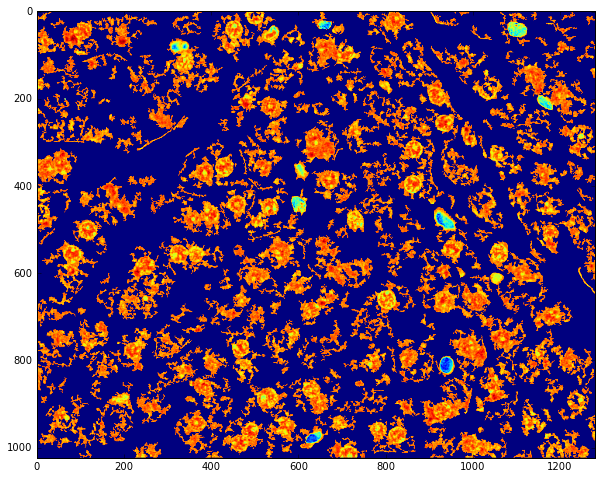

(<matplotlib.image.AxesImage at 0x1e32e63e208>, None)

In [18]:
img = cv2.imread("Dropbox/BrdUImgs/Image (41).tif",0)
thresh = cv2.threshold(img, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = 255 - thresh
t = np.zeros(thresh.shape, np.uint8)
_, cnt, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for c in cnt:
    if cv2.contourArea(c) > 100:
        cv2.drawContours(t, [c], 0, 255, -1)
plt.imshow(t, cmap = 'gray'), plt.title("Otsu"), plt.show()
m = cv2.bitwise_and(img, t)
plt.imshow(m), plt.show()

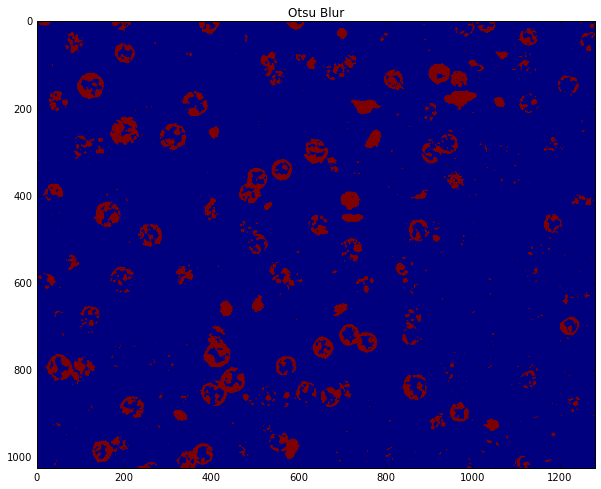

(<matplotlib.image.AxesImage at 0x1e32e83fb00>,
 None)

In [19]:
img = cv2.imread("Image4.tif",0)
blur = cv2.GaussianBlur(img, (5,5), 0)
ret, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
th = 255 - th
plt.imshow(th), plt.title("Otsu Blur"), plt.show()

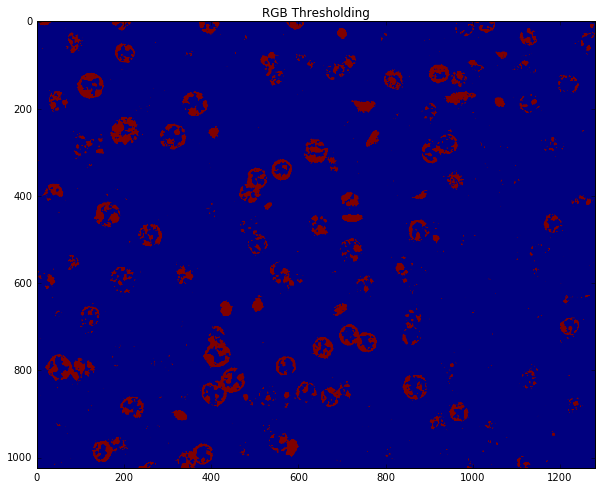

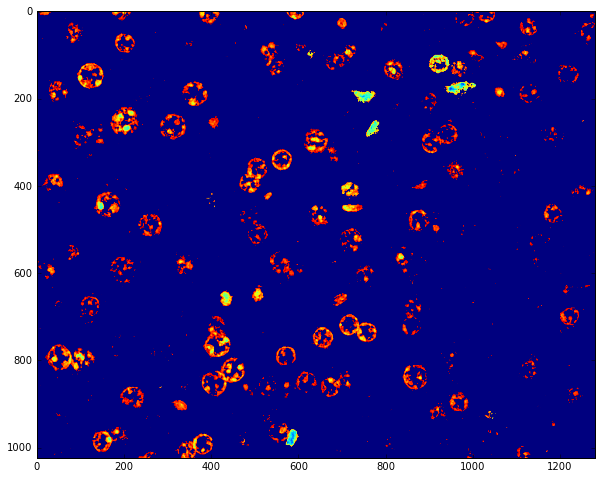

(<matplotlib.image.AxesImage at 0x1e32e5adef0>, None)

In [20]:
img = cv2.imread("Image4.tif")
thresh = cv2.inRange(img, (0,0,0), (255,255,160))
plt.imshow(thresh), plt.title("RGB Thresholding"), plt.show()
gray = cv2.imread("Image4.tif",0)
m = cv2.bitwise_and(gray, thresh)
plt.imshow(m), plt.show()

In [21]:
image = cv2.imread("coins.jpg")
thresh = cv2.inRange(image, (0,0,0),(255,255,180))

im2, contour,h = cv2.findContours(thresh,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
t1 = np.zeros(thresh.shape, np.uint8)
t2 = np.zeros(thresh.shape, np.uint8)
hull = []
for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        cv2.drawContours(t2, [cnt], 0, 255, -1)
        hull.append(cv2.convexHull(cnt))

for h in hull:
    #cv2.drawContours(t2, h, 0, 255, -1)
    cv2.fillConvexPoly(t1, h, 255)
    cv2.fillPoly(t2, h, 255)
    
plt.subplot(1,2,1),plt.imshow(t1, cmap = 'gray')
plt.subplot(1,2,2), plt.imshow(t2, cmap = 'gray'), plt.show()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
A = cv2.bitwise_and(t2, t1)
plt.imshow(A), plt.show()

D = ndimage.distance_transform_edt(A)

localMax = peak_local_max(D, indices=False, min_distance=10,labels=A)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=A)

print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

ct = []
dt = []
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(t1.shape, dtype="uint8")
    mask[labels == label] = 255
    
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts:
        if (cv2.contourArea(c) > 500):
            ct.append(cv2.contourArea(c))
            cv2.drawContours(image, [c],0,255,-1)
            ((x, y), r) = cv2.minEnclosingCircle(c)
            cv2.putText(image, "{}".format(cv2.contourArea(c)), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    #print(len(cnts))
    
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    
    #cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
plt.imshow(image), plt.show()

error: ..\..\..\modules\core\src\arithm.cpp:1906: error: (-209) The lower bounary is neither an array of the same size and same type as src, nor a scalar in function cv::inRange


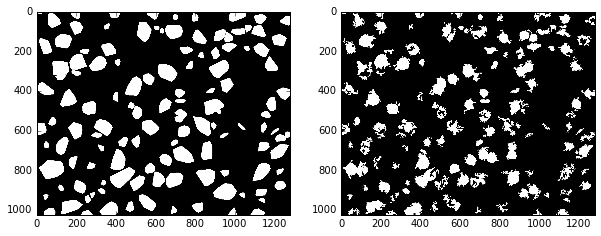

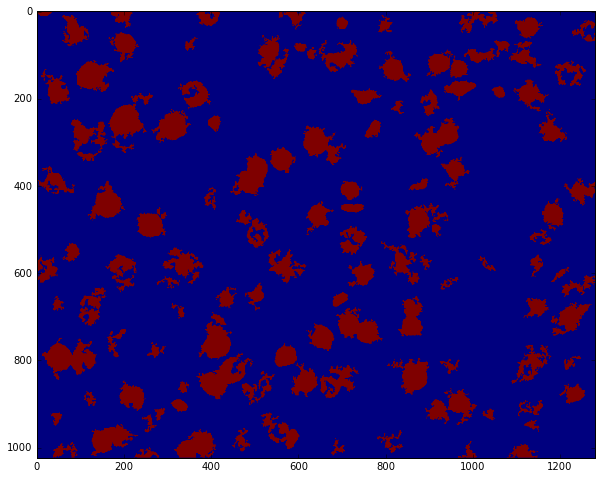

In [ ]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

image = cv2.imread("Image4.tif")
thresh = cv2.inRange(image, (0,0,0),(255,255,180))

im2, contour,h = cv2.findContours(thresh,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
t1 = np.zeros(thresh.shape, np.uint8)
t2 = np.zeros(thresh.shape, np.uint8)
hull = []
for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        cv2.drawContours(t2, [cnt], 0, 255, -1)
        hull.append(cv2.convexHull(cnt))

for h in hull:
    cv2.drawContours(t2, h, 0, 255, -1)
    cv2.fillConvexPoly(t1, h, 255)
    cv2.fillPoly(t2, h, 255)

plt.subplot(1,2,1),plt.imshow(t1, cmap = 'gray')
plt.subplot(1,2,2), plt.imshow(t2, cmap = 'gray'), plt.show()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
A = cv2.bitwise_and(t2, t1)
plt.imshow(A), plt.show()

D = ndimage.distance_transform_edt(t1)

localMax = peak_local_max(D, indices=False, min_distance=10,labels=t1)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=t1)

print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

ct = []
dt = []
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(t1.shape, dtype="uint8")
    mask[labels == label] = 255
    
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts:
        if (cv2.contourArea(c) > 500):
            ct.append(cv2.contourArea(c))
            cv2.drawContours(image, [c],0,255,-1)
            ((x, y), r) = cv2.minEnclosingCircle(c)
            cv2.putText(image, "{}".format(cv2.contourArea(c)), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    #print(len(cnts))
    
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    
    #cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
plt.imshow(image), plt.show()
cv2.imshow("Watershed", image), cv2.waitKey(-1)

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("OPEN")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("OPEN THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_BLACKHAT, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("BLACKHAT")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("BLACKHAT THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("CLOSE")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("CLOSE THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_CROSS, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("CROSS")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("CROSS THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("DILATE")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("DILATE THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_ELLIPSE, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("ELLIPSE")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("ELLIPSE THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_ERODE, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("ERODE")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("ERODE THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("GRADIENT")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("GRADIENT THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_HITMISS, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("HITMISS")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("HITMISS THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_RECT, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("RECT")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("RECT THEN FILL"), plt.show()

In [ ]:
img = cv2.imread('Image4.tif')
thresh = cv2.inRange(img, (0,0,0),(255,255,180))
opening = cv2.morphologyEx(thresh, cv2.MORPH_TOPHAT, (3,3))
im2, contour,h = cv2.findContours(opening,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t1 = np.zeros(thresh.shape, np.uint8)

for cnt in contour:
    if cv2.contourArea(cnt) > 300:
        cv2.drawContours(t1,[cnt],0,255,-1)
        
plt.subplot(1,2,1), plt.imshow(opening), plt.title("TOP HAT")
plt.subplot(1,2,2), plt.imshow(t1), plt.title("TOP HAT THEN FILL"), plt.show()

In [ ]:
#http://codegolf.stackexchange.com/questions/40831/counting-grains-of-rice

from sys import argv; from PIL import Image
# Init
I = Image.open("Image.tif"); W, H = I.size; A = W * H
D = [sum(c) for c in I.getdata()]
Bh = [0] * H; Ch = [0] * H
Bv = [0] * W; Cv = [0] * W

# Flood-fill
Background = 3 * 255 + 1; S = [0]
while S:
    i = S.pop(); c = D[i]
    if c != Background:
        D[i] = Background
        Bh[i // W] += c; Ch[i // W] += 1
        Bv[i % W] += c; Cv[i % W] += 1
        S += [(i + o) % A for o in [1, -1, W, -W] if abs(D[(i + o) % A] - c) < 10]

# Eliminate "trapped" areas
for i in range(H): Bh[i] /= float(max(Ch[i], 1))
for i in range(W): Bv[i] /= float(max(Cv[i], 1))
for i in range(A):
    a = (Bh[i // W] + Bv[i % W]) / 2
    if D[i] >= a: D[i] = Background

# Estimate grain count
Foreground = -1; avg_grain_area = 2000; grain_count = 0
for i in range(A):
    if Foreground < D[i] < Background:
        S = [i]; area = 0
        while S:
            j = S.pop() % A
            if Foreground < D[j] < Background:
                D[j] = Foreground; area += 1
                S += [j - 1, j + 1, j - W, j + W]
        grain_count += int(round(area / avg_grain_area))

# Output
print(grain_count)

In [ ]:
#http://codegolf.stackexchange.com/questions/40831/counting-grains-of-rice
import cv2
import numpy

I = cv2.imread("Image.tif", 0)
h,w = I.shape[:2]
diff = (3,3,3)
mask = numpy.zeros((h+2,w+2),numpy.uint8)
cv2.floodFill(I,mask,(0,0), (255,255,255),diff,diff)
T,I = cv2.threshold(I,180,255,cv2.THRESH_BINARY)
I = cv2.medianBlur(I, 7)

totalrice = 0
oldlinecount = 0
for y in range(0, h):
    oldc = 0
    linecount = 0
    start = 0   
    for x in range(0, w):
        c = I[y,x] < 128;
        if c == 1 and oldc == 0:
            start = x
        if c == 0 and oldc == 1 and (x - start) > 10:
            linecount += 1
        oldc = c
    if oldlinecount != linecount:
        if linecount < oldlinecount:
            totalrice += oldlinecount - linecount
        oldlinecount = linecount
print(totalrice)

In [ ]:
#http://codegolf.stackexchange.com/questions/40831/counting-grains-of-rice
import cv2
import numpy as np

I = cv2.imread("Image.tif", 0)
I = cv2.medianBlur(I, 3)
bw = cv2.adaptiveThreshold(I, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 1)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
bw = cv2.dilate(cv2.erode(bw, kernel), kernel)

print(np.round_(np.sum(bw == 0) / 2000.0))

In [ ]:
#http://docs.opencv.org/3.1.0/d2/dbd/tutorial_distance_transform.html#gsc.tab=0

img = cv2.imread("Image4.tif")

kernel = np.ones((3,3), np.uint8)
sharp = img
imgLaplacian = cv2.filter2D(sharp, cv2.CV_32F, kernel)
img = np.float32(sharp)
imgResult = sharp - imgLaplacian

imgResult = np.uint8(imgResult)
imgLaplacian = np.uint8(imgLaplacian)

plt.subplot(1,2,1),plt.imshow(imgLaplacian), plt.title("ImgLaplacian"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(imgResult), plt.title("ImgResult"), plt.xticks([]), plt.yticks([]), plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.uint8(gray)
ret, bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(bw, cmap = 'gray'), plt.title("Thresh"), plt.xticks([]), plt.yticks([]), plt.show()
bw = 255 - bw
im = cv2.GaussianBlur(bw, (0,0), 3)
sharper = cv2.addWeighted(bw, 1.5, im, -0.5, 0)
dilation = cv2.dilate(sharper, kernel, iterations = 1)
im2, contour, h = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for c in contour:
    if (cv2.contourArea(c) > 300):
        cv2.drawContours(sharper, [c], 0, 255, -1)
    
plt.imshow(sharper, cmap = 'gray'), plt.title("Thresh (Dilated/Filled/Inverted)"), plt.xticks([]), plt.yticks([]), plt.show()

dist = cv2.distanceTransform(sharper, cv2.DIST_L2, 5)
#dist = cv2.normalize(dist, 0, 1., cv2.NORM_MINMAX)
plt.imshow(dist), plt.title("Distance Transform"), plt.xticks([]), plt.yticks([]), plt.show()

ret, dist =  cv2.threshold(dist, 0.1*dist.max(), 255, 0)
dil2 = cv2.dilate(dist, kernel, iterations = 1)
plt.imshow(dil2), plt.title("Dilation"), plt.xticks([]), plt.yticks([]), plt.show()

dist_8u = np.uint8(dist_8u)
im3, ctr, h = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#markers = np.ones(dist.shape, np.uint8)

#i = 0
#for c in ctr:
#    cv2.drawContours(markers, [c], 0, 255, -1)

#cv2.circle(markers, (5,5), 3, (255,255,255), -1)
#plt.imshow(markers, cmap = 'gray'), plt.title("Markers"), plt.xticks([]), plt.yticks([]), plt.show()

ret, markers = cv2.connectedComponents(dist_8u)
markers[markers==0] = -1
markers = markers + 1
cv2.watershed(img, markers)

In [ ]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage


image = cv2.imread("Image4.tif")
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
plt.imshow(image), plt.show()
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh), plt.show()
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=10,
	labels=thresh)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
 
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    cv2.drawContours(image, cnts,0,255,-1)
    c = max(cnts, key=cv2.contourArea)
 
	# draw a circle enclosing the object
	#((x, y), r) = cv2.minEnclosingCircle(c)
	#cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	#cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 
# show the output image
plt.imshow(image), plt.show()

In [ ]:
img = cv2.imread('Image75.tif')
bl = cv2.GaussianBlur(img, (0,0),3)
gray = cv2.cvtColor(bl, cv2.COLOR_BGR2GRAY)
ave = np.average(gray)
ret, thresh = cv2.threshold(gray, ave, 255, cv2.THRESH_BINARY)

ret, conn = cv2.connectedComponents(thresh)
plt.imshow(conn), plt.show()